### Objective:
### Tag Samples With Review-Score Discrepancy (good review & low score).

In [18]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split, cross_val_score
from sentence_transformers import SentenceTransformer
from datetime import datetime
import tqdm
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import warnings
import importlib
from utils.tokenize_utils import save_embeddings_list
from utils.visualizations import ratings_boxen, reviews_style, scatter_tag_deviations, compare_score_dist, styled_hist
from models.discrepancy_model import Discrepancy_Model
from models.Ensemble_Pipeline import Ensemble_Pipeline
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS
warnings.filterwarnings("ignore")
# nltk.download("stopwords")
# nltk.download('punkt')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#load the data as full_data
df = pd.read_csv('AirlineReviews.csv')
full_data=df

## General EDA

In [5]:
#there are 22 Features in the dateset of different types.
full_data.head(5)

Aircraft    AirlineName      CabinType      DateFlown  \
0            NaN    AB Aviation  Economy Class  November 2019   
1           E120    AB Aviation  Economy Class      June 2019   
2  Embraer E120     AB Aviation  Economy Class      June 2019   
3            NaN  Aerocaribbean  Economy Class            NaN   
4            NaN  Aerocaribbean            NaN            NaN   

              DatePub  EntertainmentRating  FoodRating  GroundServiceRating  \
0  11th November 2019                    0           4                    4   
1      25th June 2019                    0           1                    1   
2      25th June 2019                    0           1                    1   
3  31st December 2010                    0           0                    0   
4  25th November 2010                    0           0                    0   

   OriginCountry  OverallScore  ...                Route SeatComfortRating  \
0    Netherlands           9.0  ...     Moroni to Moheli                 4   
1  UnitedKingdom           1.0  ...    Moroni to Anjouan                 2   
2  UnitedKingdom           1.0  ...  Anjouan to Dzaoudzi                 2   
3        Denmark           8.0  ...                  NaN                 0   
4  UnitedKingdom           1.0  ...                  NaN                 0   

  ServiceRating           Slug                          Title    TravelType  \
0             5    ab-aviation          pretty decent airline  Solo Leisure   
1             2    ab-aviation             Not a good airline  Solo Leisure   
2             1    ab-aviation   flight was fortunately short  Solo Leisure   
3             0  aerocaribbean  Aerocaribbean customer review           NaN   
4             0  aerocaribbean  Aerocaribbean customer review           NaN   

    TripVerified ValueRating WifiRating                             unique_id  
0  Trip Verified           3          0  d3b260fb-268b-4399-8a9b-2804825902c6  
1  Trip Verified           2          0  307711df-268f-4698-97b8-45729b7d972e  
2  Trip Verified           2          0  82bd2602-171d-4724-bde0-90b71621cdcf  
3            NaN           4          0  a927beb4-6244-4f5c-9dc3-09890aa3e616  
4            NaN           0          0  d7bea425-c58a-4a7e-8269-02e0e6516633  

[5 rows x 22 columns]

In [142]:
#129,455 rows
full_data.shape

(129455, 22)

In [143]:
#nulls?
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129455 entries, 0 to 129454
Data columns (total 22 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Aircraft             36424 non-null   object 
 1   AirlineName          129455 non-null  object 
 2   CabinType            126437 non-null  object 
 3   DateFlown            90993 non-null   object 
 4   DatePub              129455 non-null  object 
 5   EntertainmentRating  129455 non-null  int64  
 6   FoodRating           129455 non-null  int64  
 7   GroundServiceRating  129455 non-null  int64  
 8   OriginCountry        127777 non-null  object 
 9   OverallScore         125124 non-null  float64
 10  Recommended          129455 non-null  object 
 11  Review               128631 non-null  object 
 12  Route                90825 non-null   object 
 13  SeatComfortRating    129455 non-null  int64  
 14  ServiceRating        129455 non-null  int64  
 15  Slug             

In [144]:
#features with many null values are aircraft (28%) and tripverified (45%).
full_data.notna().mean().sort_values(ascending=True)

Aircraft               0.281364
TripVerified           0.459681
Route                  0.701595
DateFlown              0.702893
TravelType             0.704075
OverallScore           0.966544
CabinType              0.976687
OriginCountry          0.987038
Review                 0.993635
Title                  0.999969
ValueRating            1.000000
Slug                   1.000000
ServiceRating          1.000000
Recommended            1.000000
WifiRating             1.000000
GroundServiceRating    1.000000
FoodRating             1.000000
EntertainmentRating    1.000000
DatePub                1.000000
AirlineName            1.000000
SeatComfortRating      1.000000
unique_id              1.000000
dtype: float64

In [146]:
#of TripVerified values Seems Like 76% Are Verified and 24% are not Verified. There are a few values that needs fixing.
full_data['TripVerified'].value_counts(normalize=True)

Trip Verified                                0.763595
Not Verified                                 0.236204
NotVerified                                  0.000151
Trip Verified,Trip Verified                  0.000017
Not Verified,Not Verified                    0.000017
Chicago to Colorado Springs. Not Verified    0.000017
Name: TripVerified, dtype: float64

In [3]:
rating_col = full_data.columns[full_data.columns.str.contains("Rating")].tolist()
rating_col

['EntertainmentRating',
 'FoodRating',
 'GroundServiceRating',
 'SeatComfortRating',
 'ServiceRating',
 'ValueRating',
 'WifiRating']

In [ ]:
rating_col.append('OverallScore')

In [153]:
#rating cols range between 0 and 5, overallscore ranges between 1 and 10

data_describe = full_data[rating_col].describe()
data_describe


EntertainmentRating  FoodRating     GroundServiceRating  \
count  129455.000000        129455.000000  129455.000000         
mean        1.557190             1.989077       1.652010         
std         1.751076             1.774512       1.740252         
min         0.000000             0.000000       0.000000         
25%         0.000000             0.000000       0.000000         
50%         1.000000             1.000000       1.000000         
75%         3.000000             4.000000       3.000000         
max         5.000000             5.000000       5.000000         

       SeatComfortRating  ServiceRating  ValueRating    WifiRating     \
count  129455.000000      129455.000000  129455.000000  129455.000000   
mean        2.470202           2.689622       2.637527       0.453926   
std         1.620262           1.774499       1.628808       1.078274   
min         0.000000           0.000000       0.000000       0.000000   
25%         1.000000           1.000000       1.000000       0.000000   
50%         2.000000           3.000000       2.000000       0.000000   
75%         4.000000           4.000000       4.000000       0.000000   
max         5.000000           5.000000       5.000000       5.000000   

       OverallScore   
count  125124.000000  
mean        4.556408  
std         3.498833  
min         1.000000  
25%         1.000000  
50%         3.000000  
75%         8.000000  
max        10.000000

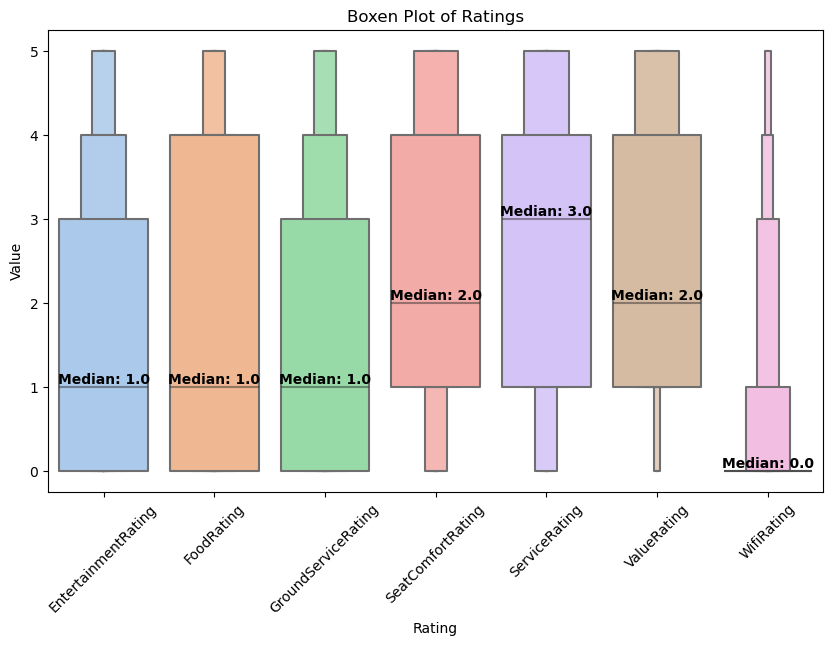

In [13]:
ratings_boxen(full_data, rating_col)

In [21]:
#lets check out some not numeric features:

#2 date columns. DatePub: Exact date. DateFlown: Month and year.
non_numeric_cols= full_data.select_dtypes(exclude='number')
non_numeric_cols.head(5)

Aircraft    AirlineName      CabinType      DateFlown  \
0            NaN    AB Aviation  Economy Class  November 2019   
1           E120    AB Aviation  Economy Class      June 2019   
2  Embraer E120     AB Aviation  Economy Class      June 2019   
3            NaN  Aerocaribbean  Economy Class            NaN   
4            NaN  Aerocaribbean            NaN            NaN   

              DatePub  OriginCountry Recommended  \
0  11th November 2019    Netherlands         yes   
1      25th June 2019  UnitedKingdom          no   
2      25th June 2019  UnitedKingdom          no   
3  31st December 2010        Denmark         yes   
4  25th November 2010  UnitedKingdom          no   

                                              Review                Route  \
0  Moroni to Moheli. Turned out to be a pretty de...     Moroni to Moheli   
1  Moroni to Anjouan. It is a very small airline....    Moroni to Anjouan   
2  Anjouan to Dzaoudzi. A very small airline and ...  Anjouan to Dzaoudzi   
3  Havana - Cayo Coco return. A one hour flight w...                  NaN   
4  Holguin to Havana last week. Okay apart from i...                  NaN   

            Slug                          Title    TravelType   TripVerified  \
0    ab-aviation          pretty decent airline  Solo Leisure  Trip Verified   
1    ab-aviation             Not a good airline  Solo Leisure  Trip Verified   
2    ab-aviation   flight was fortunately short  Solo Leisure  Trip Verified   
3  aerocaribbean  Aerocaribbean customer review           NaN            NaN   
4  aerocaribbean  Aerocaribbean customer review           NaN            NaN   

                              unique_id  
0  d3b260fb-268b-4399-8a9b-2804825902c6  
1  307711df-268f-4698-97b8-45729b7d972e  
2  82bd2602-171d-4724-bde0-90b71621cdcf  
3  a927beb4-6244-4f5c-9dc3-09890aa3e616  
4  d7bea425-c58a-4a7e-8269-02e0e6516633

In [22]:
non_numeric_cols.nunique()

Aircraft           3633
AirlineName         547
CabinType             4
DateFlown           111
DatePub            5200
OriginCountry       202
Recommended           2
Review           128425
Route             51401
Slug                548
Title             70975
TravelType            4
TripVerified          6
unique_id        129455
dtype: int64

In [72]:
#travel types
full_data['TravelType'].value_counts()

Solo Leisure      33246
Couple Leisure    23845
Family Leisure    19900
Business          14155
Name: TravelType, dtype: int64

In [25]:
#cabin types
full_data['CabinType'].value_counts()

Economy Class      102735
Business Class      16474
Premium Economy      4816
First Class          2412
Name: CabinType, dtype: int64

In [23]:
#binary yes/no var
full_data['Recommended'].value_counts()

no     77597
yes    51858
Name: Recommended, dtype: int64

In [45]:
#may i fing review-score contradictions with reccomended-score contradiction indication? seems like not... can check better later.
mask1=full_data['Recommended']=='yes'
mask2=full_data['OverallScore']==1
reviews_style(full_data[mask1 & mask2][['Title','Review', 'Recommended', 'OverallScore']].head(3))

In [64]:
#look at some relevant to my task features
reviews_df= full_data[['Title', 'Review', 'OverallScore']]

reviews_style(reviews_df.head(5))

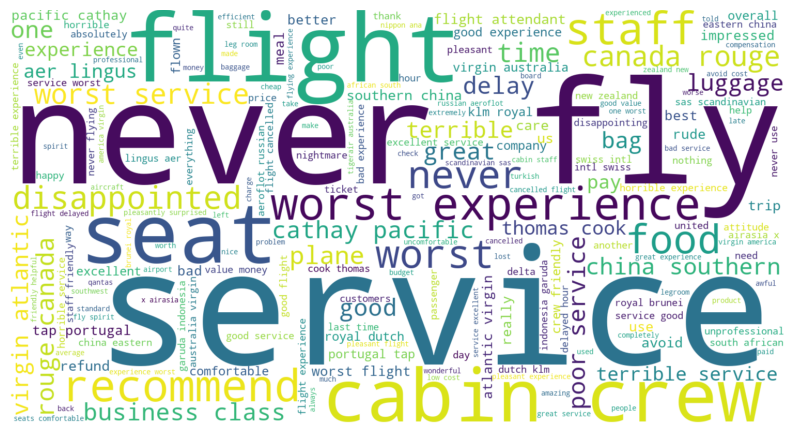

In [121]:
#Titles most common words cloud visualization. 

#Many have defualt of airline name + airline, customer or review. I have filtered them to see more patterns.
#There's a common use of sentiment words like "disappointed", "great", "good", "worst experience" etc. 
#And common use of flight related charesteristics like "seat", "service", "delay"

unwanted_words = ['air', 'customer', 'review', 'airline', 'airlines', 'lines', 'airways']
generate_word_cloud(full_data, 'Title', unwanted_words, max_words=200)

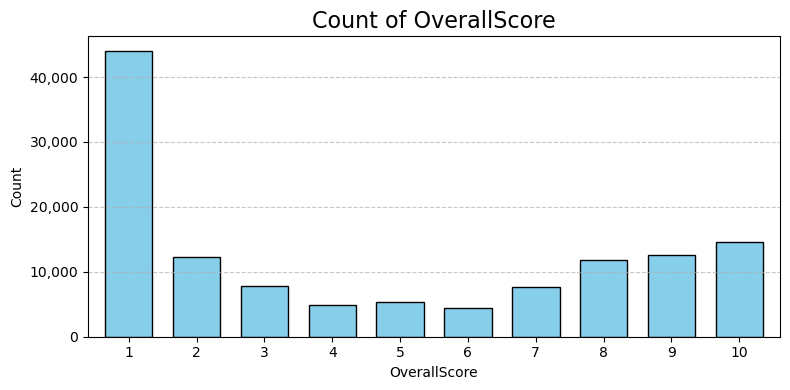

In [181]:
#Distribution Of OverallScore Column, wich contradictions from reviews i will try to locate.

#Most Ratings Are Negative. OverallScore has a Bimodal distribution with peaks at top and bottom.
styled_count_plot(full_data, 'OverallScore')

## Full Data

### preprocess

In [3]:
#preprocess for inconssistent reviews and scores tagging

def preprocess(data):
    #save old index
    data['OldIndex'] = data.index
    #remove overallscore nulls
    data = data.dropna(subset=['OverallScore'])
    #when review is nan i want to fill it with title
    data['Review']=data['Review'].fillna(data['Title'])
    #change Reviews column type to str
    data['Review']=data['Review'].astype(str)
    data['Title']=data['Title'].astype(str)
    # Reset the index and create a new index column starting from 1
    data = data.reset_index(drop=True)
    data['OverallScore'] = data['OverallScore'].astype('int64')
    return data

In [5]:
data=preprocess(full_data)

In [3]:
full_data[['Title','Review']].head(5)

Title  \
0          pretty decent airline   
1             Not a good airline   
2   flight was fortunately short   
3  Aerocaribbean customer review   
4  Aerocaribbean customer review   

                                              Review  
0  Moroni to Moheli. Turned out to be a pretty de...  
1  Moroni to Anjouan. It is a very small airline....  
2  Anjouan to Dzaoudzi. A very small airline and ...  
3  Havana - Cayo Coco return. A one hour flight w...  
4  Holguin to Havana last week. Okay apart from i...

In [4]:
#when review is nan i have title...
full_data[['Title','Review']][full_data['Review'].isnull()]

Title Review
219       average with room for improvement    NaN
631                 very polite and helpful    NaN
744                  Such a bogus airline"     NaN
979     you can't change your flight date"     NaN
1946           Flight attendants don’t care    NaN
...                                     ...    ...
128144             a very unethical company    NaN
128624       An all over no good experience    NaN
128640              Do not fly this airline    NaN
128897               Beware of this company    NaN
129027                   The value was good    NaN

[824 rows x 2 columns]

In [ ]:
#check if reviews with nans have different scores distribution
full_data[['Review', 'OverallScore']][full_data['Review'].isnull()==True]

Review  OverallScore
219     NaN    6.0         
631     NaN    9.0         
744     NaN    2.0         
979     NaN    1.0         
1946    NaN    1.0         
...       ...           ...
128144  NaN    1.0         
128624  NaN    1.0         
128640  NaN    1.0         
128897  NaN    1.0         
129027  NaN    8.0         

[824 rows x 2 columns]

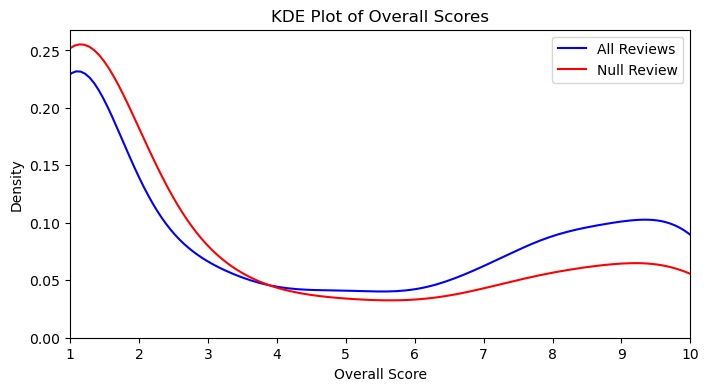

In [5]:
#The scores distribution for rows with nan reviews is pretty similar to general scores distributionץ
compare_score_dist(data=full_data, score_col='OverallScore', condition_col='Review')

In [290]:
#i will replace the empty reviews with Titles
full_data['Review']=full_data['Review'].fillna(full_data['Title'])

In [ ]:
#all numbers in OverallScore Column are natural numbers or nulls.

full_data[(reviews_df['OverallScore']%1!=0) & (full_data['OverallScore'].notnull())]


Empty DataFrame
Columns: [Aircraft, AirlineName, CabinType, DateFlown, DatePub, EntertainmentRating, FoodRating, GroundServiceRating, OriginCountry, OverallScore, Recommended, Review, Route, SeatComfortRating, ServiceRating, Slug, Title, TravelType, TripVerified, ValueRating, WifiRating, unique_id]
Index: []

[0 rows x 22 columns]

In [ ]:
#Possibly null vals represent 0 in overallscore?

#4331 rows have null value for OverScore. Since this is 3% from the data and strongly correlated to other column nulls- i will not use it for now.

full_data[full_data['OverallScore'].isnull()]
full_data[full_data['OverallScore'].isnull()].notna().mean().sort_values()


TripVerified           0.000000
OverallScore           0.000000
Aircraft               0.000231
DateFlown              0.000231
TravelType             0.000231
Route                  0.000231
CabinType              0.780420
OriginCountry          0.814592
Review                 0.999769
ValueRating            1.000000
Title                  1.000000
Slug                   1.000000
ServiceRating          1.000000
Recommended            1.000000
WifiRating             1.000000
GroundServiceRating    1.000000
FoodRating             1.000000
EntertainmentRating    1.000000
DatePub                1.000000
AirlineName            1.000000
SeatComfortRating      1.000000
unique_id              1.000000
dtype: float64

In [8]:
data['Review'].isnull().sum() # no missing reviews

0

In [7]:
len(data)

125124

In [7]:
data[data.index!=data['OldIndex']].head(5)

Aircraft AirlineName      CabinType       DateFlown             DatePub  \
84      NaN     Aeromar  Economy Class    October 2019   21st October 2019   
85      NaN     Aeromar  Economy Class  September 2019  2nd September 2019   
86      NaN     Aeromar    First Class    October 2018  22nd November 2018   
87      NaN     Aeromar  Economy Class   November 2018   6th November 2018   
88      NaN     Aeromar  Economy Class       June 2018       3rd June 2018   

    EntertainmentRating  FoodRating  GroundServiceRating OriginCountry  \
84                    1           3                    1  UnitedStates   
85                    0           1                    1        Mexico   
86                    0           3                    3        Mexico   
87                    1           1                    1  UnitedStates   
88                    0           0                    1         Chile   

    OverallScore  ... SeatComfortRating ServiceRating     Slug  \
84           1.0  ...                 1             1  aeromar   
85           2.0  ...                 2             1  aeromar   
86           1.0  ...                 3             3  aeromar   
87           1.0  ...                 1             1  aeromar   
88           1.0  ...                 0             0  aeromar   

                           Title      TravelType   TripVerified ValueRating  \
84     never again will I use it  Couple Leisure  Trip Verified           1   
85  never use this airline again  Couple Leisure  Trip Verified           1   
86  never fly with Aeromar again  Family Leisure  Trip Verified           3   
87     such bad customer service  Family Leisure  Trip Verified           1   
88       strongly advise against  Couple Leisure  Trip Verified           1   

   WifiRating                             unique_id  OldIndex  
84          1  0decd0fe-7533-4e29-8968-48e8fd67f752        89  
85          0  19ea5769-3f3a-467a-a6d2-191907dccc5a        90  
86          0  b9574ad9-9381-4c9a-873c-2f48db285695        91  
87          1  0b53d15a-4d05-4e94-b1a3-747716e3db16        99  
88          0  6e3c3312-1520-4e2a-bd52-ce8c68e25fca       100  

[5 rows x 23 columns]

### Feature Engineering

In [6]:
#create review words length feature
review_words_count= data['Review'].str.split().str.len()

data['review_words_count']=review_words_count

In [20]:
#longest review? 1058 words.
data['review_words_count'].max()

1058

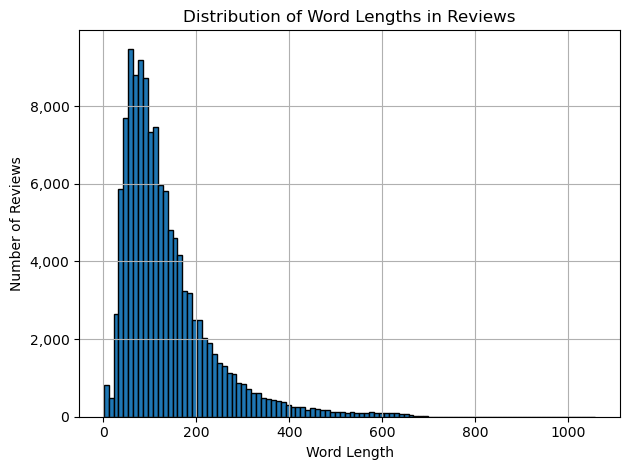

In [21]:
#Not many reviews have more then 400 words.
styled_hist(data['review_words_count'], 100)

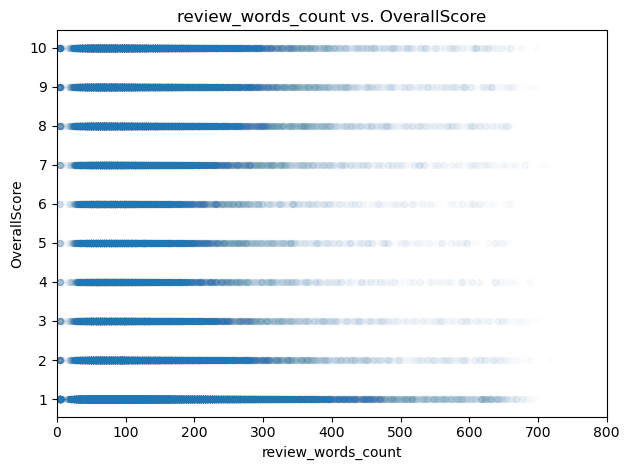

In [176]:
#show score for levels of review words length- can see differences between different levels.
styled_scatter(data, 'review_words_count', 'OverallScore')

### embeddings and model

In [21]:
#riviews list
reviews_list= data['Review'].astype(str).tolist()

#Choosing Sentence Embedding Model.
model_name = "distilbert-base-nli-stsb-mean-tokens"
model = SentenceTransformer(model_name)
embeddings = []

# Set the progress bar
model.progress_bar = True

for review in tqdm.tqdm(reviews_list):
    # Get embeddings for the review
    embeddings.append(model.encode(review))


100%|██████████| 125124/125124 [3:59:09<00:00,  8.72it/s]  


In [ ]:
df_embeddings= save_embeddings_list(embeddings, 'review_embedds')

In [27]:
df_embeddings.shape

(125124, 768)

In [7]:
#read embeddings
review_embedds = pd.read_feather('reviews_embeddings.feather')

In [8]:
review_embedds

0         1         2         3         4         5         6  \
0       0.282556 -0.287775 -0.515977  0.607247  0.086185  0.005153 -0.256900   
1      -0.427871 -0.092692 -0.231590  0.081165 -0.093915  0.514610  0.001485   
2       0.206127  0.077256  0.106587  0.044490  0.066787  0.248605 -0.500180   
3      -0.522362  0.100336  0.138848 -0.013197 -0.167226 -0.154845  0.231433   
4      -0.058437 -0.206136 -0.007734  0.564741 -0.246107  0.328283  0.077435   
...          ...       ...       ...       ...       ...       ...       ...   
125119  0.455416 -0.229832  0.386637  0.026693 -0.005352 -0.144323  0.042927   
125120 -0.092114  0.162477 -0.115130  0.254737 -0.276096 -0.008373 -0.656493   
125121  0.247114  0.101224  0.854859  0.077183  0.386252  0.116111  0.189119   
125122  0.080206  0.388128  0.504136  0.159220 -0.575155 -0.026981 -0.127790   
125123  0.351727 -0.050193  0.376862  0.063072 -0.250135  0.619474  0.271922   

               7         8         9  ...       758       759       760  \
0      -0.427660  0.936323  0.060333  ... -0.094750 -0.851784  0.166589   
1      -0.529886  0.605084  0.263048  ... -0.049264 -0.124530  0.372414   
2      -0.406408  0.233511  0.315719  ... -0.134023 -0.216901  0.039109   
3      -0.540839  1.111897 -0.288906  ... -0.366613 -0.693591 -0.057126   
4      -0.117183  0.305393 -0.123440  ... -0.426969  0.451062 -0.259374   
...          ...       ...       ...  ...       ...       ...       ...   
125119  0.080596  1.322273 -1.119570  ... -0.691581 -0.670049 -0.017754   
125120 -0.857934  0.716365 -0.551375  ... -0.632993 -0.870561  0.003540   
125121 -0.574936  0.398846 -0.284776  ... -0.637744 -0.224132  0.153787   
125122 -0.900560  0.264815 -0.371573  ... -0.030289  0.065343 -0.183334   
125123 -0.662088  0.750241  0.181778  ... -0.010068 -0.231966  0.436378   

             761       762       763       764       765       766       767  
0       0.396488 -0.080943  0.704610  0.286818  0.639017  0.170248  0.142928  
1      -0.404232 -0.027495  0.334325 -0.108264  0.376505  0.167445  0.140431  
2      -0.434229 -0.117254  0.021070  0.292187  0.274266  0.338725  0.639340  
3       0.446729  0.037009  0.366853  0.161749  0.218890 -0.238941 -0.416639  
4       0.314997  0.023128 -0.206382 -0.497004 -0.006150  0.548728  0.187054  
...          ...       ...       ...       ...       ...       ...       ...  
125119  0.118551 -0.268246  0.345668 -0.097369  0.600944 -0.000481  0.323983  
125120 -0.026490 -0.833441  0.259748 -0.210944  0.058926 -0.092067  0.168662  
125121 -0.157255 -0.218322  0.207668  0.181697 -0.073391 -0.025289 -0.320947  
125122  1.138831  0.382529  0.453924  0.017600  0.678979  0.224833 -0.050566  
125123 -0.284364  0.183322  0.103059 -0.320626  0.142090 -0.149576  0.164286  

[125124 rows x 768 columns]

In [43]:
#using Descrepancy_Model to tag review-score descrepancy

params = {
    'model_class': lgb.LGBMRegressor,
    'objective': 'regression',
    'min_split_gain': 10,
    'num_leaves': 40,
    'random_state': 42,
    'verbose': -1,
    'features': review_embedds, #only review embedds as features
    'tag_threshold': 5 #min prediction deviation from real score to tag. tag 1:prediction-score<tag treshold.

}

model = Discrepancy_Model(params)

#split
model.train_test_split(y=data['OverallScore'])

#fit
model.fit(model.X_train, model.y_train)

#predict
pd.Series(model.predict(model.X_test), index = model.X_test.index)
model.predict(model.X_train)
model.predict(model.features)

#create output dfs
#model.full_summary_df()returns full data predictions
model.summary_df(data= data, score_col='OverallScore', tagged_col='score_inconsistence')#returns samples where prediction>score with some info columns.
model.tagged_df(tag_col='score_inconsistence') #saves only tagged samples

# Calculate the Mean Squared Error for training data & test data
model.score_summary(scorer=mean_squared_error)



mean_squared_error (Train): 2.4935402414946624
mean_squared_error (Test): 3.1795630802344474
tagged samples number:  493


In [44]:
model.tag_threshold

5

In [12]:

model.summary_df.head(3)

Title  \
46863    Emirates again?  ... we laughed   
114890          Ryanair are far superior   
113233  Vietnam Airlines customer review   

                                                   Review  OverallScore  \
46863   My wife and I heard a lot about Emirates: new ...             1   
114890                           Ryanair are far superior             1   
113233  VN 661 to Singapore. Flight left on time on th...             1   

        prediction  deviations  score_inconsistence  
46863     9.400317    8.400317                    1  
114890    9.208406    8.208406                    1  
113233    9.158453    8.158453                    1

In [ ]:
#got some predictions larger then 10 and lower then 1. fixed in the predict.
model.summary_df[model.summary_df['prediction']<1]

In [14]:
reviews_style(model.tagged_df.head(5))

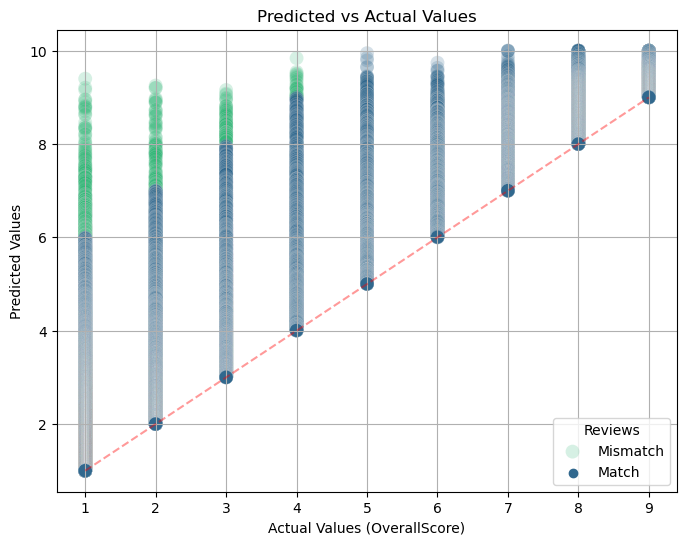

In [16]:
scatter_tag_deviations(model.summary_df, 'OverallScore', 'prediction', 'score_inconsistence')

In [19]:
#add review word length as feature, to get more accurate predictions for review length.
#using Descrepancy_Model to tag review-score descrepancy

#MSE for train 2.44 and for test 3.12
review_embedds_len=pd.concat([data['review_words_count'], review_embedds], axis=1)

params1 = {
    'model_class': lgb.LGBMRegressor,
    'objective': 'regression',
    'min_split_gain': 10,
    'num_leaves': 40,
    'random_state': 42,
    'verbose': -1,
    'features': review_embedds_len, #review embedds and words length as features
    'tag_threshold': 5 #min prediction deviation from real score to tag. tag 1:prediction-score<tag treshold.

}

model1 = Discrepancy_Model(params1)

#split
model1.train_test_split(y=data['OverallScore'])

#fit
model1.fit(model1.X_train, model1.y_train)

#predict
pd.Series(model1.predict(model1.X_test), index = model1.X_test.index)
model1.predict(model1.X_train)
model1.predict(model1.features)

#create output dfs
#model.full_summary_df()returns full data predictions
model1.summary_df(data= data, score_col='OverallScore', tagged_col='score_inconsistence')#returns samples where prediction>score with some info columns.
model1.tagged_df(tag_col='score_inconsistence') #saves only tagged samples

# Calculate the Mean Squared Error for training data & test data
model1.score_summary(scorer=mean_squared_error)

mean_squared_error (Train): 2.442527959318459
mean_squared_error (Test): 3.1231946735290386
tagged samples number:  409


In [49]:
#may be a little better results but still, reviews like #68,280 are getting tagged. if i would use title as well that wouldnt happen.
model1.tagged_df.head(5)

Title                                   \
113233       Vietnam Airlines customer review   
68280   Never again, it's not worth the money   
111191         Virgin America customer review   
47966               I had a wonderful flight    
113235       Vietnam Airlines customer review   

       Review                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          \
113233                                                                                                                                                                                                                                                                                                                                                          VN 661 to Singapore. Flight left on time on the plane was clearly quite old but clean nonetheless. The middle seat between the other passenger and me was free so it added to the level of comfort. The meal was filling and quite tasty - when you fly around Europe and get little or nothing this makes such a nice change! The cabin was quite warm. The crew did several drink runs and were always available. Would fly with them again if I was in the region.   
68280                           I was thrilled to hear that LATAM became Delta Skymiles partner, so I took a chance to fly them several times in their "Premium" cabins. I typically select window seats in the rear side of the cabin, as I think they are somewhat more private, especially with everyone tending to sit as close to the front as possible. Thus my seat was 5A with no one sitting next to me, and that was perfect. The flight was delayed, and the flight attendants asked me to give away my seat for additional crew required because of the delay and move to an aisle seat with someone sitting next to me. Great touch, especially that there were plenty of vacant seats on the flight. The food wasn't edible at all - they brought a frozen omelet for breakfast. Never again, it's not worth the money.   
111191                                                                                                                                                                                                 I flew from Las Vegas to San Fran with a connecting flight from San Fran to Philadelphia. After flying with Spirit from Philly to Las Vegas this was a welcoming experience. First time flying with Virgin I got a really good deal. Wanted to change my flight at the last min but prices were outrageous. A $900 difference. But other than that I would definitely recommend this airline to travelers. Traveled with elderly father and the wheelchair assistance and their employees were great with the airline and the employees at Las Vegas and San Fran. Philly was not overly friendly but that was to be expected.   
47966                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [161]:
#seeme like titles add extra value for the tagging:

#no missing vals after preprocess

len(data["Title"].notna())

125124

In [171]:
#Titles list To turn to embeddings. columns will be named a+number.
titles_list= data['Title'].astype(str).tolist()

#Choosing Sentence Embedding Model.
model_name = "all-MiniLM-L6-v2"
model = SentenceTransformer(model_name)
title_embeddings = []

# Set the progress bar
model.progress_bar = True

for i, title in enumerate(tqdm.tqdm(titles_list)):
    # Get embeddings for the title
    title_embeddings.append(model.encode(title))


100%|██████████| 125124/125124 [30:46<00:00, 67.76it/s]


In [175]:
title_embeddings

[array([ 8.14269707e-02, -1.17989909e-02, -3.62817459e-02,  8.43187124e-02,
        -9.22119245e-02, -1.37107074e-02,  4.06275317e-02,  1.03104040e-02,
        -3.58992182e-02,  5.73017970e-02, -2.26123631e-02,  5.87102659e-02,
        -4.86017540e-02,  9.14740376e-03, -2.58963741e-02, -8.32456164e-03,
         1.16825797e-01, -1.71844721e-01, -3.52552980e-02, -9.50511098e-02,
        -8.85548592e-02,  4.00559157e-02,  2.03695800e-02,  3.44246480e-04,
         9.33635607e-03,  1.68221630e-02,  2.83560399e-02,  4.28190455e-02,
         1.29057048e-02, -3.53006907e-02,  1.71467545e-03,  2.38126218e-02,
        -2.04325262e-02,  4.19296362e-02, -2.92233117e-02,  1.73508283e-02,
         4.31296676e-02, -3.76579612e-02,  2.79603410e-03, -3.79249156e-02,
         1.21481149e-02, -1.52303779e-03,  3.50743271e-02, -6.52126363e-03,
        -2.72580143e-02, -6.36350513e-02,  2.04075072e-02,  5.22272214e-02,
         6.68524057e-02,  4.64839861e-02,  3.30399908e-02, -4.09187637e-02,
         2.9

In [176]:
#stack and save title embeddings to a feather file 
stacked_embeddings=np.stack(title_embeddings)
df_embeddings = pd.DataFrame(stacked_embeddings)

# Rename the embedding column names
df_embeddings.columns = ['a' + str(i) for i in range(len(df_embeddings.columns))]

df_embeddings.to_feather("titles_embeddings.feather")
#df_embeddings.to_csv("titles_embeddings.csv") #backup

In [184]:
df_embeddings

a0        a1        a2        a3        a4        a5        a6        \
0       0.081427 -0.011799 -0.036282  0.084319 -0.092212 -0.013711  0.040628   
1       0.101306  0.005089 -0.025426  0.098595 -0.083992 -0.024564  0.049868   
2       0.082496  0.102309  0.022149  0.055498  0.030850  0.017526 -0.002884   
3       0.011002  0.090722 -0.037661  0.017068  0.034678  0.001074  0.048496   
4       0.011002  0.090722 -0.037661  0.017068  0.034678  0.001074  0.048496   
...          ...       ...       ...       ...       ...       ...       ...   
125119 -0.083712  0.058417 -0.030574  0.043138 -0.023215 -0.021732  0.137945   
125120 -0.083712  0.058417 -0.030574  0.043138 -0.023215 -0.021732  0.137945   
125121 -0.083712  0.058417 -0.030574  0.043138 -0.023215 -0.021732  0.137945   
125122 -0.083712  0.058417 -0.030574  0.043138 -0.023215 -0.021732  0.137945   
125123 -0.083712  0.058417 -0.030574  0.043138 -0.023215 -0.021732  0.137945   

        a7        a8        a9        ...  a374      a375      a376      \
0       0.010310 -0.035899  0.057302  ...  0.031966 -0.021682 -0.017591   
1      -0.044396 -0.015252  0.049791  ...  0.039949 -0.018759 -0.060071   
2       0.022599 -0.047314  0.022434  ...  0.029562 -0.018723 -0.079754   
3       0.003075 -0.051792 -0.033719  ... -0.013222  0.073643 -0.040781   
4       0.003075 -0.051792 -0.033719  ... -0.013222  0.073643 -0.040781   
...          ...       ...       ...  ...       ...       ...       ...   
125119 -0.003898 -0.104000  0.005255  ...  0.029066 -0.000600 -0.031602   
125120 -0.003898 -0.104000  0.005255  ...  0.029066 -0.000600 -0.031602   
125121 -0.003898 -0.104000  0.005255  ...  0.029066 -0.000600 -0.031602   
125122 -0.003898 -0.104000  0.005255  ...  0.029066 -0.000600 -0.031602   
125123 -0.003898 -0.104000  0.005255  ...  0.029066 -0.000600 -0.031602   

        a377      a378      a379      a380      a381      a382      a383      
0      -0.018358 -0.039405  0.041420  0.035886  0.016461 -0.024218  0.057814  
1      -0.024124 -0.039847  0.046811  0.023184 -0.006178 -0.045722  0.056598  
2       0.027526 -0.035291  0.019839 -0.046052 -0.018918 -0.074538 -0.016282  
3      -0.015794  0.015840 -0.016605 -0.038628 -0.075974 -0.072765  0.035264  
4      -0.015794  0.015840 -0.016605 -0.038628 -0.075974 -0.072765  0.035264  
...          ...       ...       ...       ...       ...       ...       ...  
125119 -0.009044 -0.016985  0.045019 -0.026282 -0.026505 -0.008974  0.002874  
125120 -0.009044 -0.016985  0.045019 -0.026282 -0.026505 -0.008974  0.002874  
125121 -0.009044 -0.016985  0.045019 -0.026282 -0.026505 -0.008974  0.002874  
125122 -0.009044 -0.016985  0.045019 -0.026282 -0.026505 -0.008974  0.002874  
125123 -0.009044 -0.016985  0.045019 -0.026282 -0.026505 -0.008974  0.002874  

[125124 rows x 384 columns]

In [9]:
title_embedds = pd.read_feather('titles_embeddings.feather')

In [28]:
title_embedds.head(5)

a0        a1        a2        a3        a4        a5        a6        \
0  0.081427 -0.011799 -0.036282  0.084319 -0.092212 -0.013711  0.040628   
1  0.101306  0.005089 -0.025426  0.098595 -0.083992 -0.024564  0.049868   
2  0.082496  0.102309  0.022149  0.055498  0.030850  0.017526 -0.002884   
3  0.011002  0.090722 -0.037661  0.017068  0.034678  0.001074  0.048496   
4  0.011002  0.090722 -0.037661  0.017068  0.034678  0.001074  0.048496   

   a7        a8        a9        ...  a374      a375      a376      a377      \
0  0.010310 -0.035899  0.057302  ...  0.031966 -0.021682 -0.017591 -0.018358   
1 -0.044396 -0.015252  0.049791  ...  0.039949 -0.018759 -0.060071 -0.024124   
2  0.022599 -0.047314  0.022434  ...  0.029562 -0.018723 -0.079754  0.027526   
3  0.003075 -0.051792 -0.033719  ... -0.013222  0.073643 -0.040781 -0.015794   
4  0.003075 -0.051792 -0.033719  ... -0.013222  0.073643 -0.040781 -0.015794   

   a378      a379      a380      a381      a382      a383      
0 -0.039405  0.041420  0.035886  0.016461 -0.024218  0.057814  
1 -0.039847  0.046811  0.023184 -0.006178 -0.045722  0.056598  
2 -0.035291  0.019839 -0.046052 -0.018918 -0.074538 -0.016282  
3  0.015840 -0.016605 -0.038628 -0.075974 -0.072765  0.035264  
4  0.015840 -0.016605 -0.038628 -0.075974 -0.072765  0.035264  

[5 rows x 384 columns]

In [29]:
title_embedds.shape

(125124, 384)

In [21]:
#trying To predict only using title embeddings.
#using Descrepancy_Model to tag review-score descrepancy

params2 = {
    'model_class': lgb.LGBMRegressor,
    'objective': 'regression',
    'min_split_gain': 10,
    'num_leaves': 40,
    'random_state': 42,
    'verbose': -1,
    'features': title_embedds, #only title embedds as features
    'tag_threshold': 6 #min prediction deviation from real score to tag. tag 1:prediction-score<tag treshold.

}

model2 = Discrepancy_Model(params2)

#split
model2.train_test_split(y=data['OverallScore'])

#fit
model2.fit(model2.X_train, model2.y_train)

#predict
pd.Series(model2.predict(model2.X_test), index = model2.X_test.index)
model2.predict(model2.X_train)
model2.predict(model2.features)

#create output dfs
#model.full_summary_df()returns full data predictions
model2.summary_df(data= data, score_col='OverallScore', tagged_col='score_inconsistence')#returns samples where prediction>score with some info columns.
model2.tagged_df(tag_col='score_inconsistence') #saves only tagged samples

# Calculate the Mean Squared Error for training data & test data
model2.score_summary(scorer=mean_squared_error)

mean_squared_error (Train): 4.735818254781483
mean_squared_error (Test): 5.295060708425003
tagged samples number:  372


In [48]:
#missing info with only titles.
model2.tagged_df.head(7)

Title                                    \
82213                meal offerings were great   
11514                  the crew were wonderful   
43062                        Excellent airline   
45327                  the price was very good   
106285              cabin staff were excellent   
79414            Highly recommend this airline   
68307   a great level of improvement is needed   

       Review                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    \
82213                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               It was pretty good, staff were helpful. They support passengers better at their bases instead of foreign airports since I saw a different handler assisting SAS. Drink service was beyond some other airlines and meal offerings were great. Cabin temperature was pleasantly warm. Speedy but very polite.   
11514   Haultuco to Toronto. The airplane was clean, well stocked and the crew were wonderful. Our biggest complaint is how cold the cabin became an hour after take off. It was so cold that people were complaining. I had an Air transat blanket previously bought on another flight we took from Portugal last year. This along with 3 sweaters and a hoody, and wool socks were not enough. The flight attendant was rubbing and blowing into her hands to stay warm at the back of the airplane.  About two hours after take off, I found the cabin to be a bit more comfortable, not blowing cold air on your face, (it was not the vents above us blowing the air). It was still cold, but not freezing.  This is the third time this has happened going on an Air Transat charter. It was cold going to Mexico this last time, but not as freezing as our previous trip down to Mexico last year and coming back this year. We enjoy the service and the flight, but unless something is done about the cabin temperature, we will ...   
43062                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [36]:
#using Descrepancy_Model to tag review-score descrepancy


combined_embedds = pd.concat([review_embedds_len, title_embedds], axis=1)

params = {
    'model_class': lgb.LGBMRegressor,
    'objective': 'regression',
    'min_split_gain': 10,
    'num_leaves': 40,
    'random_state': 42,
    'verbose': -1,
    'features': combined_embedds, #use title, review and word len as features.
    'tag_threshold': 5 #min prediction deviation from real score to tag. tag 1:prediction-score<tag treshold.

}

model = Discrepancy_Model(params)

#split
model.train_test_split(y=data['OverallScore'])

#fit
model.fit(model.X_train, model.y_train)

#predict
pd.Series(model.predict(model.X_test), index = model.X_test.index)
model.predict(model.X_train)
model.predict(model.features)

#create output dfs
#model.full_summary_df()returns full data predictions
model.summary_df(data= data, score_col='OverallScore', tagged_col='score_inconsistence') #returns samples where prediction>score with some info columns.
model.tagged_df(tag_col='score_inconsistence') #saves only tagged samples

# Calculate the Mean Squared Error for training data & test data
model.score_summary(scorer=mean_squared_error)

mean_squared_error (Train): 2.198197235520864
mean_squared_error (Test): 2.7983764548795653
tagged samples number:  303


In [37]:
#looks like to much decisions are made based on titles
reviews_style(model.tagged_df.head(10))

In [56]:
model1.summary_df.head(1)

Title                              \
113233  Vietnam Airlines customer review   

       Review                                                                                                                                                                                                                                                                                                                                                                                                                                                                  \
113233  VN 661 to Singapore. Flight left on time on the plane was clearly quite old but clean nonetheless. The middle seat between the other passenger and me was free so it added to the level of comfort. The meal was filling and quite tasty - when you fly around Europe and get little or nothing this makes such a nice change! The cabin was quite warm. The crew did several drink runs and were always available. Would fly with them again if I was in the region.   

        OverallScore  prediction  deviations  score_inconsistence  
113233  1             9.143465    8.143465    1

In [34]:
model1.prediction_col

array([8.75089833, 1.85211248, 4.33322302, ..., 8.57851685, 6.66275083,
       1.00395579])

In [57]:
model2.summary_df.head(1)

Title                       \
82213  meal offerings were great   

      Review                                                                                                                                                                                                                                                                                                        \
82213  It was pretty good, staff were helpful. They support passengers better at their bases instead of foreign airports since I saw a different handler assisting SAS. Drink service was beyond some other airlines and meal offerings were great. Cabin temperature was pleasantly warm. Speedy but very polite.   

       OverallScore  prediction  deviations  score_inconsistence  
82213  1             9.063794    8.063794    1

In [59]:
model2.prediction_col

array([6.3549407 , 1.87757918, 4.56336799, ..., 5.7435225 , 5.7435225 ,
       5.7435225 ])

In [36]:
#set ensemble pipeline hyperparameters

#looks like best results so far

params3={
    'model1_predict': model1.prediction_col,
    'model2_predict': model2.prediction_col,
    'model1_y_test': model1.y_test,
    'model1_y_train': model1.y_train,
    'tag_threshold': 6,  #min prediction deviation from real score to tag. tag 1:prediction-score<tag treshold.
    'threshold_low_score': 3, #if model 2 predicts < 'threshold_low_score', then model 2 weight changes.
    'model2_base_weight': 0.1, #base model2 weight
    'model2_adjusted_weight': 0.5 #changed lower weight

}

ensemble=Ensemble_Pipeline(params3)

ensemble.ensemble_df(data=data, score_col='OverallScore', tagged_col='score_discrepancy')

ensemble.sorted_tags() 

ensemble.score_summary(mean_squared_error)


mean_squared_error (Train): 2.289712203572705
mean_squared_error (Test): 2.898947595692765
tagged samples number:  58


In [51]:
discrepancy= ensemble.tagged_df

In [52]:
discrepancy.head(20)

Title                                   \
111191         Virgin America customer review   
47966               I had a wonderful flight    
113233       Vietnam Airlines customer review   
79414           Highly recommend this airline   
27894         Bangkok Airways customer review   
64147                 superb service on board   
73443       Malaysia Airlines customer review   
82213               meal offerings were great   
113235       Vietnam Airlines customer review   
15532                in flight crew are great   
114890               Ryanair are far superior   
64247         Jetblue Airways customer review   
112846                Volotea customer review   
13711              Air France customer review   
114587        Virgin Atlantic customer review   
43062                       Excellent airline   
5               Aerocaribbean customer review   
124796               second flight was better   
81225   Royal Brunei Airlines customer review   
17826                  attendant was friendly   

       Review                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    \
111191                                                                                                                                                                                                                                                                                                                                                                                                           I flew from Las Vegas to San Fran with a connecting flight from San Fran to Philadelphia. After flying with Spirit from Philly to Las Vegas this was a welcoming experience. First time flying with Virgin I got a really good deal. Wanted to change my flight at the last min but prices were outrageous. A $900 difference. But other than that I would definitely recommend this airline to travelers. Traveled with elderly father and the wheelchair assistance and their employees were great with the airline and the employees at Las Vegas and San Fran. Philly was not overly friendly but that was to be expected.   
47966                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  Riyadh to Lahore. I had a wonderful flight with this airline. The flight was on-time and the crew were friendly. The WI-FI and connectivity were poor but the in-flight entertainmen

In [58]:
discrepancy['Recommended']= data['Recommended']

In [59]:
#at this point seems like recommended could add some info, but would also screen some seemingly fitting review.
#as there are few reviews. would not use this feature.
discrepancy.head(20)

Title                                   \
111191         Virgin America customer review   
47966               I had a wonderful flight    
113233       Vietnam Airlines customer review   
79414           Highly recommend this airline   
27894         Bangkok Airways customer review   
64147                 superb service on board   
73443       Malaysia Airlines customer review   
82213               meal offerings were great   
113235       Vietnam Airlines customer review   
15532                in flight crew are great   
114890               Ryanair are far superior   
64247         Jetblue Airways customer review   
112846                Volotea customer review   
13711              Air France customer review   
114587        Virgin Atlantic customer review   
43062                       Excellent airline   
5               Aerocaribbean customer review   
124796               second flight was better   
81225   Royal Brunei Airlines customer review   
17826                  attendant was friendly   

       Review                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    \
111191                                                                                                                                                                                                                                                                                                                                                                                                           I flew from Las Vegas to San Fran with a connecting flight from San Fran to Philadelphia. After flying with Spirit from Philly to Las Vegas this was a welcoming experience. First time flying with Virgin I got a really good deal. Wanted to change my flight at the last min but prices were outrageous. A $900 difference. But other than that I would definitely recommend this airline to travelers. Traveled with elderly father and the wheelchair assistance and their employees were great with the airline and the employees at Las Vegas and San Fran. Philly was not overly friendly but that was to be expected.   
47966                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  Riyadh to Lahore. I had a wonderful flight with this airline. The flight was on-time and the crew were friendly. The WI-FI and connectivity were poor but the in-flight entertainmen